In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
with open('../processed_data/model_genes.txt', 'rb') as reader:
    selected_genes = set([s.strip() for s in reader.readlines()])

In [4]:
f = fns[0]
tissue = f.split('-')[0]
df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)    
id2gene = [str(s) for s in df_exp.columns if s.split('.')[0] in selected_genes]
assert(len(id2gene) == len(selected_genes))

In [5]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [6]:
len(id2tissue)

7051

In [7]:
import numpy as np
data = np.vstack(data)

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf


In [9]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
            h_in = h_out
            #
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_in = tf.layers.batch_normalization(h_in, training=is_train, name = 'h%02d/batch_norm' % i)
                h_in = tf.layers.dropout(h_in, rate=0.2, training=is_train)
            #h_in = tf.nn.relu(h_in) 
            h_in = tf.nn.tanh(h_in)   
    return h_out

In [10]:
num_gene = len(id2gene)

In [11]:
data.shape

(7051, 11890)

In [12]:
beta1 = 0.5

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'is_training')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')

    theta_mat = [512, 1024, 1024, num_gene]
    
    logit_rec = DNN(inputs, theta_mat, is_training, scope = 'AE', reuse = False)
    
    rec_loss_l1 = tf.reduce_mean(tf.abs(logit_rec - inputs))
    rec_loss_l2 = tf.reduce_mean(tf.square(logit_rec - inputs))
    
    d_loss = rec_loss_l2
    #'''
    for v in tf.contrib.framework.get_variables_to_restore(include=['AE/h00/dense']): 
        if 'dense' not in v.name:
             continue
        
        print v.name
        d_loss += l1_penalty * (tf.reduce_sum(tf.abs(v)) + tf.reduce_sum(tf.square(v))) * 0.5
        
    #'''
    
    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    d_optim = tf.train.AdamOptimizer(d_lrd, beta1=beta1)  
    #d_optim = tf.train.RMSPropOptimizer(d_lrd, momentum=0.0)
    #d_optim = tf.train.GradientDescentOptimizer(d_lrd)  
    #d_optim = tf.train.MomentumOptimizer(d_lrd, momentum=0.5)  
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = d_optim.minimize(d_loss)


AE/h00/dense/kernel:0


In [13]:
sess = tf.Session()

In [14]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :]
test_data = data[ind_test, :]

num_sample = train_data.shape[0]

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
iter_counter = 0
errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0

num_batch = num_sample

for idx in range(100000):
    lrd = 1e-3 / np.sqrt(idx * 0.0005 + 1.0)
    l1_val = 0.0000
    #l1_val = 0.001 * (1.0 + float(idx // 10000))
    
    batch_ind = np.random.choice(num_sample, size=num_batch)
    batch_x = train_data[batch_ind].astype('float32')
        
        
    # updates the discriminator
    feed_dict={inputs: batch_x, 
               is_training:True,
               l1_penalty: l1_val,
               #noise_level: 0.05, 
               d_lrd: lrd,
                }
        
    val, _ = sess.run([rec_loss_l2, d_train_op], feed_dict=feed_dict)
        
    errD += val
    D_count += 1.0
        
            
    if idx % 100 == 0:
        errD = errD / D_count

        feed_dict={inputs: test_data, 
               is_training:False,
               }            

        test_errD1 = sess.run(rec_loss_l2, feed_dict=feed_dict)


        msr = "iter: %4d, train_loss: %.4f, test_loss: %.4f" \
            % (idx, errD,test_errD1)
        print(msr)
        errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0
            
        iter_counter += 1

iter:    0, train_loss: 1.0562, test_loss: 0.9894
iter:  100, train_loss: 0.7382, test_loss: 0.7619
iter:  200, train_loss: 0.6545, test_loss: 0.7656
iter:  300, train_loss: 0.6390, test_loss: 0.7711


KeyboardInterrupt: 

In [149]:
w0 = tf.contrib.framework.get_variables_to_restore(include=['AE/h00/dense'])[0]

In [150]:
w0_val = sess.run(w0)

In [151]:
np.sum(np.abs(w0_val) < 5e-7) / float(w0_val.size)

0.0040777439024390245

In [152]:
np.mean(np.abs(w0_val))

9.2195856e-05

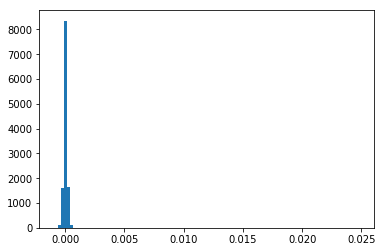

In [153]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 0], bins = 100)
plt.show()

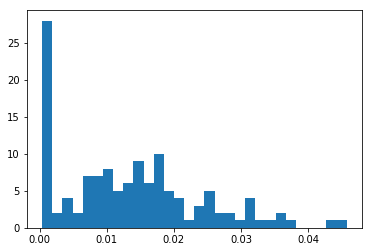

In [154]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [155]:
np.abs(w0_val[:, 0]).max()

0.024789946

In [156]:
for i in range(100):
    #thre = (0.01 * np.abs(w0_val[:, i])).max()
    thre = 3.0 * w0_val[:, i].std()
    print i, np.sum(np.abs(w0_val[:, i]) > thre ), thre, np.max(np.abs(w0_val[:, i]))

0 8 0.0010581901296973228 0.024789946
1 51 0.00025303734582848847 0.00039466907
2 5 0.001149238902144134 0.035709612
3 76 0.0004220012779114768 0.0058439695
4 41 0.0006423283775802702 0.017390234
5 92 0.0006112472765380517 0.007463942
6 14 0.0008519894618075341 0.01762989
7 12 0.001012420398183167 0.032468602
8 2 0.0009522505570203066 0.03089138
9 45 0.0005884643906028941 0.0107670855
10 19 0.0006575564184458926 0.0145378625
11 38 0.0007721545407548547 0.009486576
12 93 0.00028608286811504513 0.0006040081
13 51 0.0006120928446762264 0.007586219
14 84 0.00026675197295844555 0.00045051912
15 19 0.0009323853591922671 0.025584487
16 13 0.0008798388589639217 0.02479107
17 22 0.0008691157854627818 0.01755311
18 16 0.0008241062751039863 0.018865114
19 85 0.0003174400917487219 0.0005267034
20 7 0.0011168954952154309 0.037692
21 8 0.000968083186307922 0.028793732
22 19 0.0007139798544812948 0.01117492
23 91 0.0002778394191409461 0.0004577781
24 89 0.00036632505361922085 0.0033018885
25 80 0.000

In [65]:
for i in range(10):
    print np.where(np.abs(w0_val[:, i]) > (3.0 * w0_val[:, i].std()))[0]

[   15   198   299   314   343   376   583   844  1070  1486  1615  2074
  2142  2181  2418  3003  3190  3289  3363  3479  3506  3704  3953  4000
  4226  4392  4574  4740  4873  5266  5297  5689  5802  5858  6494  6857
  6920  7049  7560  7924  8147  8177  8180  8233  8371  8373  9152  9428
  9490  9858 10039 10089 10102 10253 10292 10435 10502 10672 10699 11309
 11549 11655 11666 11753 11888]
[   52    89   252   434   774  1068  1703  2001  2082  2199  2264  2585
  2793  3302  3318  3656  3679  3774  3956  4571  4757  4855  4897  4910
  4942  5029  5058  5117  5397  5468  5718  5848  5918  6041  6176  6275
  6325  6787  7221  7292  7496  7577  7591  7680  7793  7887  8033  8075
  8147  8187  8246  8376  8431  8542  8616  8803  8893  9430  9657  9836
  9890 10009 10492 10566 10935 11461 11629 11778 11843 11871]
[  104   396   479   508   542   554   766   783  1043  1354  1485  1539
  1841  2021  2155  2309  2428  2623  2847  2857  2989  3347  3556  3681
  3760  4099  4248  4772  4948

In [66]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [ ]:
for i in np.where(np.abs(w0_val[:, 53]) > (3.0 * w0_val[:, 53].std()))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

In [ ]:
for i in np.where(np.abs(w0_val[:, 138]) > (3.0 * w0_val[:, 138].std()))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

In [ ]:
gid2gn

In [133]:
feed_dict={inputs: test_data, 
           is_training:False,
           l1_penalty: l1_val,
           #noise_level: 0.05, 
           d_lrd: lrd,
            }

rec_val = sess.run(logit_rec, feed_dict=feed_dict)

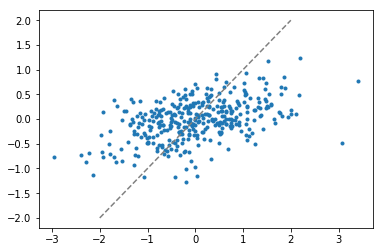

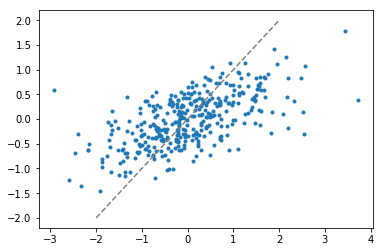

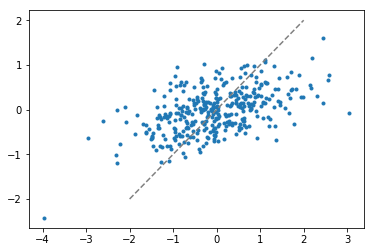

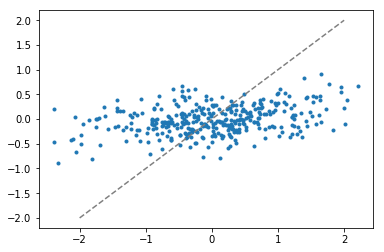

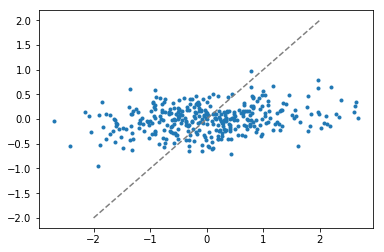

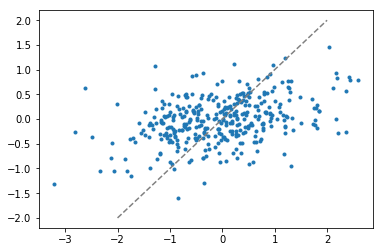

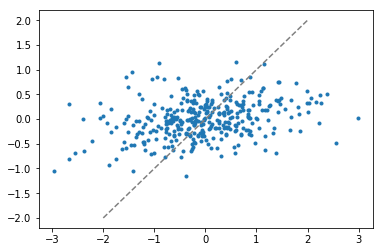

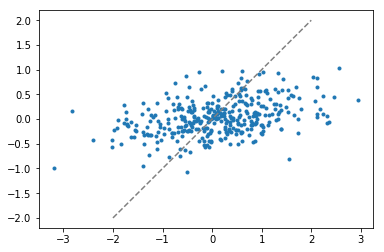

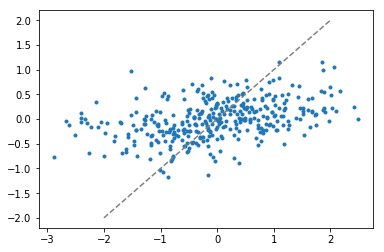

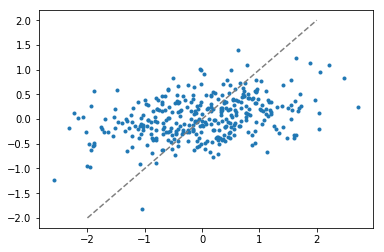

In [134]:
for i in range(1000, 2000, 100):
    plt.plot(test_data[:, i], rec_val[:, i], '.')
    plt.plot([-2.0, 2.0], [-2.0, 2.0], '--', color = 'gray')
    plt.show()

In [163]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 1024)

In [164]:
clf.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [165]:
clf.explained_variance_ratio_.sum()

0.6362681478565909

In [166]:
test_rec = clf.inverse_transform(clf.transform(test_data))

In [167]:
np.mean((test_rec - test_data) ** 2)

0.5277768799164849

In [168]:
train_rec = clf.inverse_transform(clf.transform(train_data))
np.mean((train_rec - train_data) ** 2)

0.3616700752854487